# Assignment 4: Bayesian Mixture Models

STATS305C, Stanford University, Spring 2022

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/assignments/hw4/hw4.ipynb)


---

**Name:**
Isaac K-M

**Names of any collaborators:**
Saskia C.

---



In this homework assignment we will investigate image segmentation ---specifically, separating the background from the foreground of the image. To do so, you'll fit Bayesian mixtures of Gaussians using the expectation-maximization (EM) algorithm.

### Background: Image Segmentation
The figure below shows the original input image and the resulting segmentations into background and foreground. By the end of this assignment, you will have implemented the algorithm to achieve this segmentation.

Reference on image segmentation: https://en.wikipedia.org/wiki/Image_segmentation


<img src='https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw4/images/fox_seg.png' width=800px>




## Model

We will use a simple mixture model to cluster the pixels (with the number of clusters $K = 2$ in our image segmentation problem). The likelihood is a mixture of Gaussian distributions.

\begin{align}
x_n \mid z_n, \{\mu_k, \Sigma_k\}_{k=1}^K &\sim \mathcal{N}(\mu_{z_n}, \Sigma_{z_n}) \\
z_n \mid \pi &\sim \text{Categorical}(\pi)
\end{align}

where $x_n \in \mathbb{R}^D$ is distributed according to a Gaussian distribution with the specified mean, $\mu_k$, and covariance, $\Sigma_k$, for its corresponding cluster $z_n = k$,
and $z_n$ is distributed as a multinomial with hyperparameter $\pi$. 
We will represent the images as a set of $N$ pixels, $\{x_n\}_{n=1}^N$, each in $D=3$ dimensional space, since there are three color channels (red, green, and blue).

We specify the following priors on $\mu_k$, $\Sigma_k$, and $\pi$.
- Assume a normal-inverse-Wishart prior prior for each cluster mean and covariance.
\begin{align} 
p(\mu_k, \Sigma_k) &= \mathrm{IW}(\Sigma_k \mid \Sigma_0, \nu_0) \, \mathcal{N}(\mu_k \mid \mu_0, \kappa_0^{-1} \Sigma_k)
\end{align}
Here $\Sigma_0, \nu_0, \mu_0, \kappa_0$ are hyper-parameters.

- We give a symmetric Dirichlet distribution prior to the mixing proportions, $\pi$:
$$ 
p(\pi \mid \alpha) = \text{Dirichlet}(\alpha 1_K)
$$
where $1_K$ is an all-ones vector of length $K$ and $\alpha$ is a hyperparameter.

# Problem 1 [math]: EM calculations
In this problem, you will derive the EM procedure for our Bayesian model.
For notational simplicity, let 
$$\theta = (\{\mu_k, \Sigma_k\}_{k=1}^K, \pi)$$
be the tuple of parameters we wish to estimate via EM.
Let $\theta^{(i)}$ be the parameter value at iteration $i$.
Recall the EM procedure is given by two steps:

- **Expectation step (E-step)**:
Compute
\begin{align}
q_n(z_n)
&=
p(z_n \mid x_n, \theta^{(i)})
\end{align}

- **Maximization step (M-step)**:
Find new parameters 
\begin{align}
\theta^{(i+1)}
=
\underset{\theta}{\operatorname{argmax}} 
\mathbb{E}_{q}
[\log p(\mathbf{X}, \mathbf{Z}, \theta)]
\end{align}

You will need these derivations to be correct for the implementation in Problem 2 to be correct, so we highly recommend taking the time to double-check them.

## Problem 1a: Derive the posterior distribution for $q_n(z_n) = p(z_n | x_n, \theta)$.


---

We have straightforwardly, where $p$ is the complete joint probability (likelihood + priors $\Lambda$):
\begin{align}
p(z_n = k|x_n, \theta, \Lambda) 
&\propto 
p(Z, X, \theta) \\
&=
\prod_{m=1}^N p(z_m, x_m, \theta, \Lambda)\\
&\propto p(z_n=k, x_n, \theta)p(\theta | \Lambda) \\
&\propto p(x_n|z_n=k, \theta)p(z_n|\theta)p(\theta|\Lambda)\\
&\propto p(x_n|z_n=k, \theta)p(z_n|\theta) \\
&=\mathcal{N}(x_n|z_n = k, \mu_{z_n}, \Sigma_{z_n})\pi_{z_n}\\
&=\mathcal{N}(x_n|\mu_{k}, \Sigma_{k})\pi_{k}.
\end{align}
However, this is true for all $z_n = 1, \ldots, K$, and we know that probabilities sum to 1. Hence, we must have
$$
\sum_{j=1}^K p(z_n = j|x_n, \theta, \Lambda) = 1.
$$
The only way that we can have
$$
p(z_n = k|x_n, \theta, \Lambda) \propto \mathcal{N}(x_n|\mu_{k}, \Sigma_{k})\pi_{k}
$$
and the aforementioned sum is if
$$
p(z_n = k|x_n, \theta, \Lambda) = \frac{ \mathcal{N}(x_n|\mu_{k}, \Sigma_{k})\pi_{k}}{
\sum_{j=1}^K \mathcal{N}(x_n|\mu_{j}, \Sigma_{j})\pi_{j}
}
$$
This is our result.

---

## Problem 1b: Derive the expected log probability

Show that 
\begin{align}
\mathbb{E}_q\left[ \log p(X, Z, \theta) \right]
&= 
\underbrace{\sum\limits_{k=1}^K
\left[ 
\sum\limits_{n=1}^N 
\left[ 
\omega_{nk}
\log \mathcal{N}(x_n \mid \mu_{k}, \Sigma_k)
\right]
+
\log p(\mu_k, \Sigma_k)
\right]}_{\mathcal{L}_1(\mu, \Sigma)}
\\&\qquad +
\underbrace{\sum\limits_{k=1}^K
\left[
\sum_{n=1}^N
\left[\omega_{nk} \log \pi_k \right]
+ (\alpha_k-1) \log \pi_k
\right]}_{\mathcal{L}_2(\pi)}
+
C
\end{align}
for some constant $C$, where $\omega_{nk} = q_n(z_n =k)$, and
where $\mathcal{L}_1, \mathcal{L}_2$ represent the terms in the expected log probability that depend on $\{\mu_k, \Sigma_k\}_{k=1}^K$ and $\pi$, respectively.


---

Initially treating $Z$ as a vector (for each row), we have 
\begin{align}
E_{Z\sim q} \log p(X, Z, \theta) 
&\propto 
E_{Z\sim q}\log \bigg[
\bigg(
\prod_{n=1}^N \prod_{k=1}^K
[N(x_n | \mu_k, \Sigma_k)\pi_k]^{\delta(z_n = k)}
\bigg)
\prod_{k=1}^K p(\mu_k, \Sigma_k)\pi_k^{\alpha_k - 1}\bigg]\\
&=
E_{Z\sim q} \bigg[
\bigg(
\sum_{n=1}^N \sum_{k=1}^K
[\delta(z_n = k)\log \mathcal{N}(x_n | \mu_k, \Sigma_k) + \delta(z_n = k)\log \pi_k]
\bigg) \\
&\hspace{2.5cm}
+\sum_{k=1}^K \log p(\mu_k, \Sigma_k) + (\alpha_k - 1)\log \pi_k\bigg] + C\\
&=
E_{Z\sim q} \bigg[
\sum_{n=1}^N \sum_{k=1}^K
[\delta(z_n = k)\log \mathcal{N}(x_n | \mu_k, \Sigma_k) + \delta(z_n = k)\log \pi_k]\bigg] \\
&\hspace{2.5cm}
+E_{Z\sim q}\bigg[\sum_{k=1}^K \log p(\mu_k, \Sigma_k) + (\alpha_k - 1)\log \pi_k\bigg] + C\\
&=
\bigg[
\sum_{z_1}^K\sum_{z_2}^K\ldots \sum_{z_n}^K \omega_{1, z_1}\ldots\omega_{N, z_N}
\sum_{n=1}^N \sum_{k=1}^K
[\delta(z_n = k)\log \mathcal{N}(x_n | \mu_k, \Sigma_k) + \\
&\hspace{2.5cm}
\delta(z_n = k)\log \pi_k]
\bigg]
+\sum_{k=1}^K \log p(\mu_k, \Sigma_k) + (\alpha_k - 1)\log \pi_k + C\\
&=
\bigg[
\sum_{n=1}^N \sum_{z_n = 1}^K \omega_{n, z_n}\sum_{k=1}^K
[\delta(z_n = k)\log \mathcal{N}(x_n | \mu_k, \Sigma_k) + 
\delta(z_n = k)\log \pi_k]
\bigg] \\
&\hspace{2.5cm}
+\sum_{k=1}^K \log p(\mu_k, \Sigma_k) + (\alpha_k - 1)\log \pi_k + C\\
&=
\bigg[
\sum_{n=1}^N \sum_{z_n = 1}^K \omega_{n, z_n}[\log \mathcal{N}(x_n | \mu_k, \Sigma_k) + 
\log \pi_k]
\bigg] \\
&\hspace{2.5cm}
+\sum_{k=1}^K \log p(\mu_k, \Sigma_k) + (\alpha_k - 1)\log \pi_k + C\\
\end{align}

As desired.

---

## Problem 1c: Expand $\mathcal{L}_1$ in exponential family form.

Show that $\log p(x_n\mid z_n=k, \mu_k, \Sigma_k)$ and $\log p(\mu_k, \Sigma_k)$ can be represented as the following:

\begin{align}
\log p(x_n\mid z_n=k, \mu_k, \Sigma_k)
&=
t(x_n)^\top \eta_k - A(\eta_k) + c
\\\\
\log p(\mu_k, \Sigma_k)
&=
\phi^\top \eta_k - \nu A(\eta_k) + c' \\
&
\end{align}
for some contants $c$, $c'$, functions $t$, $A$ (**explicitly find these**), hyperparameters $\phi$, $\nu$ (**explicitly find these**), where,
\begin{align*}
\eta_k &:= \left(-\frac{1}{2}\log|\Sigma_k|, -\frac{1}{2}\Sigma_k^{-1}, \Sigma_k^{-1} \mu_k, -\frac{1}{2} \mu_k^\top \Sigma_k^{-1} \mu_k \right) \\
\end{align*}

Deduce that $\mathcal{L}_1$ can be written as
\begin{align}
\mathcal{L}_1(\mu, \Sigma)
&=
\sum\limits_{k=1}^K
\left[
\sum\limits_{n=1}^N
\left[
\omega_{nk}
(t(x_n)^\top \eta_k - A(\eta_k))
\right]
+
\phi^\top \eta_k - \nu A(\eta_k)
\right] + c
\\
&=
\sum\limits_{k=1}^K
\left[
\phi_{k}^\top \eta_k
- \nu_{k}^\top A(\eta_k)
\right] + c
\end{align}
with
\begin{align}
\phi_{k}
&=
\phi + \sum\limits_{n=1}^N \omega_{n,k} t(x_n)
\\
\nu_{k}
&=
\nu + \sum\limits_{n=1}^N \omega_{n,k}
\\
\omega_{n,k}
&=
q_n(z_n=k)
\end{align}
Conclude that each summand of $\mathcal{L}_1$ is the log-pdf (up to a constant) of some
Normal-Inverse-Wishart (NIW) distribution of $(\mu_k, \Sigma_k)$. 

#### **Likelihood**. 
First, we have
\begin{align}
\log p(x_n\mid z_n=k, \mu_k, \Sigma_k)
&=
\log \mathcal{N}(x_n\mid \mu_k, \Sigma_k) \\
&=
-\frac{1}{2}\log|\Sigma_k| -\frac{1}{2}(x_n - \mu_k)^T\Sigma_k^{-1}(x_n = \mu_k)\\
&=
-\frac{1}{2}\log|\Sigma_k| -\frac{1}{2}x_n^T \Sigma_k^{-1} x_n \\
&\hspace{1.5cm}
+ x_n^T \Sigma_k^{-1} \mu_k -\frac{1}{2}\mu_k^T \Sigma_k^{-1} \mu_k\\
&=
-\frac{1}{2}\log|\Sigma_k| + tr\{-\frac{1}{2} \Sigma_k^{-1} x_nx_n^T\} \\
&\hspace{1.5cm}
+ x_n^T \Sigma_k^{-1} \mu_k -\frac{1}{2}\mu_k^T \Sigma_k^{-1} \mu_k \\
&=
\eta_{k, 1} + tr\{\eta_{k, 2} x_nx_n^T\} 
+ x_n^T \eta_{k, 3} -\eta_{k, 4}.
\end{align}

Hence, 
$A(\eta_k) = 0$, as well as 
$t(x)^T = [1, x_nx_n^T, x_n^T, 1]$ suffices, provided we are comfortable with the trace manipulation. If we are not comfortable with that, we could observe $tr\{\eta_{k, 2}x_nx_n^T\} = vec(x_nx_n^T)^Tvec(\eta_{k, 2})$, and proceed under a reparameterized $\tilde \eta_{2, k} = vec(\eta_{2, k})$ with $t(x)_2^T = vec(x_nx_n^T)$. But the relationship is generally clear.

#### **Prior**
Next, for the NIW, we have
\begin{align}
\log p(\mu_k, \Sigma_k)
&=
\log\bigg[ 
\frac{k_0^{D/2}|\Sigma_0|^{v_0/2}}{
2^{(v_0 + 1)D/2 \pi^{D/2}\Gamma_D(v_0 / 2)}
}
\bigg]
-\frac{v_0 + D + 2}{2}\log|\Sigma_k|\\
&\hspace{1.5cm}
-\frac{k_0}{2}\mu_k\Sigma_k^{-1}\mu_k + k_0 \mu_o^T\Sigma_k^{-1}\mu_k
-\frac{k_0}{2}\mu_0\Sigma_k^{-1}\mu_0 \\
&\hspace{1.5cm}
-\frac{1}{2}tr\{\Sigma_0\Sigma_k^{-1}\} \\
&=
c'
+(v_0 + D + 2)\cdot \eta_{k, 1} + k_0 \eta_{k, 4} + k_0 \mu_0\eta_{k, 3}\\
&\hspace{1.5cm} + k_0 tr\{\eta_{k, 2}\mu_0\mu_0^T\} - tr\{\Sigma_0 \eta_{k, 2}\}\\
&=
c'
+(v_0 + D + 2)\cdot \eta_{k, 1} + k_0 \eta_{k, 4} + k_0 \eta_{k, 3}\\
&\hspace{1.5cm} + tr\{[k_0\mu_0\mu_0^T + \Sigma_0]\eta_{k, 2}\}.
\end{align}
Hence, we may extract
$$
\phi = [v_0 + D + 2, [k_0\mu_0\mu_0^T + \Sigma_0], k_0\mu_0, k_0]
$$
suffices, where $A=0$ still and hence $\nu$ irrelevant.

#### **Posterior**
Substituting these results into our form for the above, we have:
\begin{align}
\mathcal{L}_1
&=
\sum\limits_{k=1}^K
\left[ 
\sum\limits_{n=1}^N 
\left[ 
\omega_{nk}
\log p(x_n \mid \mu_{k}, \Sigma_k)
\right]
+
\log p(\mu_k, \Sigma_k)
\right] \\
&=
\sum\limits_{k=1}^K
\left[ 
\sum\limits_{n=1}^N 
\left[ 
\omega_{nk}
\log \mathcal{N}(x_n \mid \mu_{k}, \Sigma_k)
\right]
+
\log p(\mu_k, \Sigma_k)
\right] \\
&=
\sum\limits_{k=1}^K
\left[
\sum\limits_{n=1}^N
\left[
\omega_{nk}
(t(x_n)^\top \eta_k - A(\eta_k))
\right]
+
\phi^\top \eta_k - \nu A(\eta_k)
\right] + c + c' \\
&=
\sum\limits_{k=1}^K
\left[
\underbrace{
\bigg(
\sum\limits_{n=1}^N\left[
\omega_{nk}
t(x_n)^\top\right] + \phi^T
\bigg)
}_{\phi_k}
\eta_k
-
\underbrace{
\bigg(
\sum\limits_{n=1}^N
\left[\omega_{nk}\right] + \nu
\bigg) 
}_{\nu_k}
A(\eta_k)
\right] + c + c'
\end{align}

In other words, we get *another* exponential family form for a NIW, and by pattern matching, we see
\begin{align}
\phi_k^T
&= 
\bigg(
\sum\limits_{n=1}^N\left[
\omega_{nk}
t(x_n)^\top\right] + \phi^T
\bigg) \\
&=
\bigg\langle \nu_0 + D + 2 + \sum_{n}\omega_{n, k}, \\
&\hspace{1.15cm} \kappa_0\mu_0\mu_0^T + \Sigma_0 + \sum_{n}\omega_{n, k}x_nx_n^T, \\
&\hspace{1.15cm} \kappa_0\mu_0^T + \sum_{n} \omega_{n, k}x_n^T, \\
&\hspace{1.15cm} \kappa_0 + \sum_{n} \omega_{n, k}\bigg\rangle.
\end{align}
These sufficient statistics define/induce our $\nu, \Sigma, \mu, \kappa$ NIW parameters.

## Problem 1d: Maximize $\mathcal{L}_1$.

Find the mode of an NIW distribution for $(\mu, \Sigma)$ with parameters 
$(\Sigma_0, \nu_0, \kappa_0, \mu_0)$.
Use this result and (c) to find the closed-form solution for maximizing $\mathcal{L}_1$
w.r.t. $\mu_k, \Sigma_k$.

---

Consider a generic $NIW(\mu, \Sigma | \Sigma_0, \nu_0, \kappa_0, \mu_0)$. Straightforwardly -- regardless of covariance structure, we know from the multivariate normal that
$$
\mu^* = \mu_0,
$$
as for any $\Sigma'$ (MAP or not), we have
$$
\mu^*= 
\underset{\mu}{\arg\max}
p_N(\mu |\mu_0, \Sigma')p_{IW}(\Sigma' | \Sigma_0, \nu_0, \kappa_0)
=
\underset{\mu}{\arg\max}
p_N(\mu |\mu_0, \Sigma') = \mu_0,
$$
which just reduces to the mode of an MVN. 


The covariance is more involved. However, we know that at the MAP $(\mu^*, \sigma^*)$, it will still be the case that $\mu^* = \mu_0$, so we plug-in:

\begin{align}
\Sigma^*
&=
\underset{\Sigma}{\arg\max}
p_{NIW}(\mu, \Sigma | \Sigma_0, \nu_0, \kappa_0, \mu_0) \\
&=
\underset{\Sigma}{\arg\max}
\log p_{NIW}(\mu, \Sigma | \Sigma_0, \nu_0, \kappa_0, \mu_0) \\
&=
\underset{\Sigma}{\arg\max}\bigg[
\log p_{N}(\mu | \Sigma) + 
\log p_{IW}(\Sigma | \Sigma_0, \nu_0, \kappa_0)\bigg] \\
&=
\underset{\Sigma}{\arg\max}\bigg[
C + \log[|\Sigma|^{-1/2}]  
- \frac{1}{2}\exp(\mu^* - \mu_0)^T\Sigma^{-1}(\mu^* - \mu_0)) \\
&\hspace{1.5cm}
+ \log p_{IW}(\Sigma | \Sigma_0, \nu_0, \kappa_0)
\bigg] \\
&=
\underset{\Sigma}{\arg\max}\bigg[
C + \log[|\Sigma|^{-1/2}]  
- \frac{1}{2}\exp(\mu_0 - \mu_0)^T\Sigma^{-1}(\mu_0 - \mu_0)) \\
&\hspace{1.5cm}
+ \log p_{IW}(\Sigma | \Sigma_0, \nu_0, \kappa_0)
\bigg] \\
&=
\underset{\Sigma}{\arg\max}\bigg[
C + -\frac{1}{2}\log|\Sigma| + \log p_{IW}(\Sigma | \Sigma_0, \nu_0, \kappa_0)
\bigg] \\
&=
\underset{\Sigma}{\arg\max}\bigg[
C -\frac{1}{2}\log|\Sigma| + C' -\frac{\nu_0 + D + 1}{2}\log|\Sigma_k|
-\frac{1}{2}tr(\exp(\Sigma_0\Sigma^{-1}
\bigg] \\
&=
\underset{\Sigma}{\arg\max}\bigg[
C'' -\frac{\nu_0 + D + 2}{2}\log|\Sigma_k|
-\frac{1}{2}tr(\exp(\Sigma_0\Sigma^{-1}))
\bigg].
\end{align}

Now, this is the argmax over the log-kernel of a $NIW(\Sigma_0, \nu_0 + 1, \kappa_0)$. And from here, we take the mode of a NIW, i.e.
$$
\frac{1}{\nu_0 + D + 2}\Sigma_0.
$$

By straightforward pattern matching, we can then extract:

- $\tilde \nu_k = \nu_0 + \sum_n \omega_{n, k}$

- $\tilde \kappa_k = \kappa_0 + \sum_n \omega_{n, k}$

- $\tilde \mu_k = \frac{1}{\tilde \kappa_k} \sum_n \omega_{n, k}x_n$

- $\tilde \Sigma_k = \Sigma_0 + \kappa_0 \mu_0\mu_0^T - \tilde \kappa_k \tilde \mu_k \tilde\mu_k^T + \sum_n \omega_{n, k} x_n x_n^T$

These formulae can be readily vectorized across $k=1, \ldots, K$; notably, it may be helpful to think of the $\sum_n \omega_{n, k}$ as "soft" counts or sums.

---

## Problem 1e: Maximize $\mathcal{L}_2$.

Find the maximizing solution $\pi^*$ of $\mathcal{L}_2$.


---

From the log-likelihood/density above, we first have
\begin{align}
\mathcal{L}_{2}
 &= \sum_k \bigg[\sum_n \omega_{n, k}\log\pi_k\bigg]\log \pi_k + (\alpha_k - 1)\log\pi_k \\
 &=
 \sum_k \bigg(\alpha_k - 1 + \sum_n \omega_{n, k}\bigg)\log \pi_k.
\end{align}
Hence, wrt a particular $k$, we get 
$$
\frac{d\mathcal{L}_2}{d\pi_k} = \frac{\bigg(\alpha_k - 1 + \sum_n \omega_{n, k}\bigg)}{\pi_k}
$$
However, as this is a discrete probability, we also have the constraint that
$$
\sum_k \pi_k = 1.
$$
Thus, for the purposes of a Lagrangian, we introduce
$$
s(\pi) = \sum_k \pi_k \implies s(\pi) = 1, \nabla_\pi s(\pi) = \vec 1
$$
and proceed to solve fixed points of
$$
\mathcal{L}_2(\pi) - \lambda s(\pi).
$$
This is achieved via diffentiation:
$$
0 = \nabla_\pi \mathcal{L}_2(\pi) - \lambda \vec 1,
$$
which gives a system of equations of the form
$$
\frac{\bigg(\alpha_k - 1 + \sum_n \omega_{n, k}\bigg)}{\pi_k} = \lambda
$$
$$
\implies 
$$
$$
\bigg(\alpha_k - 1 + \sum_n \omega_{n, k}\bigg) = \lambda \pi_k
$$
$$
\implies 
$$
$$
\sum_j^K \lambda\pi_j = \lambda \sum_j \pi_j = \lambda
$$
and 
$$
\sum_j^K \lambda\pi_j = \lambda \sum_j \bigg(\alpha_j - 1 + \sum_n \omega_{n, j}\bigg) = \lambda.$$

This gives the desired
$$
\pi_k = 
\frac{\bigg(\alpha_k - 1 + \sum_n \omega_{n, k}\bigg)}{\sum_j^K \bigg(\alpha_j - 1 + \sum_n \omega_{n, j}\bigg)}.
$$



---

# Problem 2 [code]: Implement EM for the Gaussian mixture model

We have provided starter code below.
First, you need to fill it with your own implementation of the EM algorithm. This entails writing three functions:
1. `log_probability`, which computes the log probability $\log p(X, \theta)$ 
2. `e_step`, which computes the posteriors $q_n(z_n)$ for each data point, fixing the current parameters.
3. `m_Step`, which returns new parameters, fixing the current posteriors.

Then, you will test your code on a simple example, using the code we have proved.

You may not rely on external implementations such as those offered by Tensorflow or scikit-learn.


## Setup

In [1]:
import torch
from torch.distributions import MultivariateNormal, Categorical, Dirichlet

from tqdm.auto import trange
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

## Helpers

We have provided a helper function to compute the inverse Wishart log probability since this is not one of the standard distributions in `torch.distributions`.

In [2]:
def invwishart_log_prob(Sigma, nu0, Sigma0):
    """
    Helper function to compute the inverse Wishart log probability, since its
    not given in torch.distributions.

    Args:

    Sigma:      (..., D, D) batch of covariance matrices
    nu0:        scalar degree of freedom of inverse Wishart distribution
    Sigma0:     (D, D) scale matrix for inverse Wishart distribution

    Returns:

    lp:         (...,) a batch of log probabilities
    """
    D = Sigma.shape[-1]
    assert Sigma.shape[-2:] == (D, D)
    assert Sigma0.shape[-2:] == (D, D)
    nu0 = torch.tensor(nu0)

    lp = -(nu0 + D + 1) / 2 * torch.logdet(Sigma)
    lp -= torch.linalg.solve(Sigma, Sigma0)\
        .diagonal(dim1=-1, dim2=-2).sum(axis=-1) / 2

    # log normalizing constant
    lp += nu0 / 2 * torch.logdet(Sigma0)
    lp -= nu0 * D / 2 * torch.log(torch.tensor(2.0))
    lp -= torch.special.multigammaln(nu0 / 2, D)
    return lp

## Problem 2a: Implement the `log_probability` function.

In [3]:
def log_probability(X, mus, Sigmas, pi,
                    alpha, mu0, kappa0, nu0, Sigma0):
    """
    Compute the log probability \log p(X, \theta), summing over the discrete
    cluster assignments.

    Hint: You may use the invwishart_log_prob function above.
    Hint: You may also want to use torch.logsumexp to do the sum over z.

    Args:
    - X:        (N, D) tensor of data points.
    - mus:      (K, D) tensor of cluster means.
    - Sigmas:   (K, D, D) tensor of cluster covariances.
    - pi:       (K,) tensor of cluster weights.
    - alpha:    (K,) concentration of the Dirichlet prior.
    - mu0:      (D,) tensor with the prior mean.
    - kappa0:   scalar prior precision
    - nu0:      scalar prior degrees of freedom
    - Sigma0:   (D, D) tensor of prior scale of the covariance.

    Returns:
    - lp:       scalar log probability of the data and parameters, summing over
                the discrete latent variables
    """
    lp = 0

    K, D = mus.shape
    N = X.shape[0]

    ###################################
    ### Part 1: the likelihood part ###
    ###################################

    # X: (N, D) --> (N, K, D)
    X_cast = X.repeat(K, 1, 1).swapaxes(0, 1)

    # log of the normal likelihood
    log_lik_xn = torch.distributions.MultivariateNormal(
        loc=mus.unsqueeze(0), # mu: (K, D) --> (1, K, D)
        covariance_matrix=Sigmas.unsqueeze(0) # cov: (K, D, D) --> (1, K, D, D)
    ).log_prob(X_cast) # --> (N, K)

    # log of the mixing param
    log_pi = torch.log(pi.repeat(N, 1))

    # the two things multiplied together: pi_k * N(x_n | mu_k, Sigma_k)
    assert log_pi.shape == log_lik_xn.shape
    log_lik_softcluster = torch.add(log_pi, log_lik_xn) # (N, K)

    # logsumexp: note it sums over rows
    log_lik = torch.logsumexp(log_lik_softcluster, 1) # --> (N, ); still have to take outer n sum

    ###################################
    ### Part 2: NIW prior ###
    ###################################

    # log_norm_prior = torch.distributions.MultivariateNormal()
    log_norm_prior = torch.distributions.MultivariateNormal(loc=mu0, covariance_matrix=Sigma0 / kappa0).log_prob(mus)
    log_iw_prior = invwishart_log_prob(Sigmas, nu0, Sigma0)
    assert log_norm_prior.shape == log_iw_prior.shape
    log_niw_prior = torch.add(log_norm_prior, log_iw_prior)

    ###################################
    ### Part 3: Dirichlet prior ###
    ###################################
    log_dir_prior = torch.distributions.Dirichlet(alpha).log_prob(pi)

    ### put it all together ###
    lp = (
        log_lik.sum() 
        + log_niw_prior.sum()
        + log_dir_prior
    )
    return lp


## Problem 2b: Implement the `e_step` function

In [4]:
def e_step(X, mus, Sigmas, pi):
    """
    Perform one E step to compute the posterior 

        q_n(z_n) = p(z_n | x_n, \theta)

    for each data point. 

    Args:
    - X:        (N, D) tensor of data points
    - mus:      (K, D) tensor of cluster means
    - Sigmas:   (K, D, D) tensor of cluster covariances
    - pi:       (K,) tensor of cluster weights

    Returns:
    - Q:        (N, K) tensor of responsibilities; i.e. posterior probabilities. 
                Each row should be non-negative and sum to one
    """
    N, D = X.shape
    K, _ = mus.shape
    q = torch.zeros((N, K))

    log_normal = torch.distributions.MultivariateNormal(
        loc=mus, #.unsqueeze(0), # (K, D)
        covariance_matrix=Sigmas # (K, D, D)
    ).log_prob(
        X.unsqueeze(1) # (N, 1, D)
    )
    log_pi = torch.log(pi).unsqueeze(0) # (1, K)
    logits = torch.add(log_normal, log_pi) # (N, K)
    q_new = torch.nn.functional.softmax(logits)
    return q_new
    

## Problem 2c: Implement the `m_step` function

In [16]:
def m_step(X, q, alpha, mu0, kappa0, nu0, Sigma0):
    """
    Perform one M-step to find new parameters given the current posterior
    and hyperparameters.

    Args:
    - X:        (N, D) data matrix
    - q:        (N, K) responsibilities; i.e. posterior probabilities
    - alpha:    (K,) concentration of the Dirichlet prior
    - mu0:      (D,) tensor with the prior mean
    - kappa0:   scalar prior precision
    - nu0:      scalar prior degrees of freedom
    - Sigma0:   (D, D) tensor of prior scale of the covariance

    Returns:
    - mus:      (K, D) new means for each cluster
    - Sigmas:   (K, D, D) new covariances for each cluster
    - pi:       (K,) new cluster probabilities
    """

    N, D = X.shape
    _, K = q.shape

    ### parameterize the NIW ###

    ### X.T @ W @ X, but W is a K-dim diagonal
    WX = torch.mul(
        X.unsqueeze(2), # (N, D, 1)
        q.unsqueeze(1)  # (N, 1, K)
    ) # --> (N, D, K); listcomp over K

    XTWX = torch.stack([X.T @ WX[:, :, k] for k in range(K)])

    ### K is the first dimension everywhere

    ### v': v0 + \sum_{n} w_{n, k}
    nu_post = nu0 + q.sum(axis=0) # (K, ) #  + D + 2
    assert nu_post.shape == torch.Size([K])

    ### k': k0 + \sum_{n} w_{n, k}
    kappa_post = kappa0 + q.sum(axis=0) # (K, )
    assert kappa_post.shape == torch.Size([K])

    ### u': (1 / k') * (k0u0 + \sum_{n}w_{n, k} x_n)
    mu_post = kappa0 * mu0 + torch.mul(
        q.T.unsqueeze(2), # (K, N, 1)
        X.unsqueeze(0) # (1, N, D)
    ).sum(axis=1) # --> (K, D)
    mu_post = torch.divide(mu_post, kappa_post.unsqueeze(1)) # (K, D) / (K, 1) --> (K, D)
    assert mu_post.shape == torch.Size([K, D])


    ### Sigma': Sigma0 + k0u0u0^T + \sum_{n}w{n, k}x_nx_n^T - k'uu'
    Sigma_post = torch.add(
        # (D, D) -> (1, D, D)
        torch.add(Sigma0, kappa0 * torch.outer(mu0, mu0)).unsqueeze(0),
        # (K, D, D)
        # torch.stack([X.T @ torch.diag(qk) @ X for qk in q.T])
        XTWX 
    ) # -> (K, D, D)
    assert Sigma_post.shape == torch.Size([K, D, D])
    kuuT= torch.stack(
        [ # my nonclever attempt after failing at broadcasting
            kappa_post[k] * torch.outer(mu_post[k], mu_post[k]) 
            for k in range(K)
        ]
    ) # (K, D, D)
    assert kuuT.shape == torch.Size([K, D, D])
    Sigma_post = torch.add(Sigma_post, -kuuT) # (K, D, D)


    mus_map = mu_post
    Sigmas_map = torch.mul(
        # + 2 for MAP
        (1. / (nu_post + D + torch.tensor(2.))).unsqueeze(1).unsqueeze(2), # (K, 1, 1)
        Sigma_post # (K, D, D)
    ) # --> (K, D, D)

    ### Pi ###
    pi_unnorm = q.sum(axis=0) + alpha - torch.tensor(1.) # (K, )
    pi_map = torch.divide(pi_unnorm, torch.sum(pi_unnorm))


    return mus_map, Sigmas_map, pi_map

## EM function [given]

We've provided an `em` function to run EM on a given dataset with the specified hyperparameters.

In [17]:
def em(X, 
       K=2, 
       n_iter=100, 
       alpha=torch.ones(3),
       mu0=torch.zeros(3),
       kappa0=1.0,
       nu0=4.0,
       Sigma0=torch.eye(3),
       debug_verbose=False
):
    """
    EM algorithm.

    Args:
    - X: Matrix of size (N, D). Each row of X stores one data point
    - K: the desired number of clusters in the model. Default: 2
    - n_iter: number of iterations of EM. Default: 100
    - alpha0: prior concentration of cluster probabilities
    - mu0, kappa0, nu0, Sigma0: parameters of normal-inverse-Wishart prior.
        Their shapes must be consistent with D, the data dimension.
        
    Returns:
    - mus: cluster means
    - Sigmas: cluster covariances
    - pi: cluster assignment probabilities
    - q: posterior probability of Z | X, mus, Sigmas, pi with final params.
    """
    N, D = X.shape
    assert alpha.shape == (K,)
    assert mu0.shape == (D,)
    assert Sigma0.shape == (D, D)
    hypers = (alpha, mu0, kappa0, nu0, Sigma0)

    # Initialize cluster parameters
    pi = alpha / torch.sum(alpha)
    mus = X[Categorical(logits=torch.zeros(N)).sample((K,))]
    Sigmas = Sigma0.repeat(K, 1, 1)

    # Initialize log prob outputs
    lps = []

    # Run EM
    for _ in trange(n_iter):
        if debug_verbose:
          print("entering E=step")
        q = e_step(X, mus, Sigmas, pi)
        if debug_verbose:
          print("survived E-step")
          print("entering logprob")
        lp_iter = log_probability(X, mus, Sigmas, pi, *hypers)
        lps.append(lp_iter)
        if debug_verbose:
          print(f"survived logprob: {lp_iter}")
          print("entering M-step")
        mus, Sigmas, pi = m_step(X, q, *hypers)
        if debug_verbose:
          print("survived m-step")
        
    # Run one last E-step to tighten the bound
    q = e_step(X, mus, Sigmas, pi)
    lps.append(log_probability(X, mus, Sigmas, pi, *hypers))

    return torch.tensor(lps), mus, Sigmas, pi, q

## Test your implementation on a toy dataset
Test your example on a synthetic data set.

For example, the ground truth could be two clusters, with means $[5,5]$ 
and $[8,8]$ with identity covariance matrices, respectively.
You could generate $100$ points in each cluster. 

Whichever example you choose, be sure to specify it and show that your implementation roughly recovers the ground truth by displaying the cluster means/covariances.

In [18]:
def confidence_ellipse(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Modified from: https://matplotlib.org/3.5.0/gallery/\
        statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    mean: vector-like, shape (n,)
        Mean vector.
        
    cov : matrix-like, shape (n, n)
        Covariance matrix.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    # compute the 2D covariance ellipse
    pearson = cov[0, 1] / torch.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = torch.sqrt(1 + pearson)
    ell_radius_y = torch.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), 
                      width=ell_radius_x * 2, 
                      height=ell_radius_y * 2,
                      facecolor=facecolor, 
                      **kwargs)

    # Calculating the standard deviation
    # the square root of the variance and multiplying
    # with the given number of standard deviations.
    scale = torch.sqrt(torch.diag(cov) * n_std)
    
    # Transform the ellipse by rotating, scaling, and translating
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(*scale) \
        .translate(*mean)
    ellipse.set_transform(transf + ax.transData)

    # Add the patch to the axis
    return ax.add_patch(ellipse)


def test_toy(seed=305+ord('c'),
             n_test=200,
             mus=torch.Tensor([[5,5], [8,8]]),
             covs=torch.eye(2).repeat(2,1,1),
             K=2,
             n_iter=300,
             ):
    K, D = mus.shape
    assert covs.shape == (K, D, D)
    
    # Generate n_test random data points from each of K classes and combine
    torch.manual_seed(seed)
    X = MultivariateNormal(mus, covs).sample((n_test,)).reshape(-1, D)
    
    # Run the EM algorithm
    em_results = em(X, K=K, n_iter=n_iter,
                    alpha=torch.ones(K),
                    mu0=torch.zeros(D),
                    kappa0=1.0,
                    nu0=3.0,
                    Sigma0=torch.eye(D))
    
    # Return data and results
    return (X, *em_results)

In the toy example, I run into the dreaded PSD error; however, things work out during full-on segmentation a bit later on. 

In [19]:
K = 2
X, lps, means, covs, probs, q = test_toy(K=K)

# display the results  
for k in range(K):
    print("Cluster ", k, ":")
    print("\t mu:    ", means[k,:])
    print("\t Sigma: ", covs[k,:,:])
    print("\t probs: ", probs[k])
    print("")

# Plot the log probabilities over EM iterations
plt.figure()
plt.plot(lps[1:])
plt.xlabel("EM iteration")
plt.ylabel("log probability")

# create a second figure to plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))

# plot scatter 
ax.scatter(X[:,0], X[:,1], c=torch.argmax(q, 1), marker='.')

for i in range(K):
  # plot mean as red dots
  ax.scatter(means[i,0], means[i,1], c='red')

  # plot covariance ellipses
  confidence_ellipse(means[i,:], covs[i], ax, n_std=1, 
                     edgecolor='red', linestyle=':')
  confidence_ellipse(means[i,:], covs[i], ax, n_std=2, 
                     edgecolor='red', linestyle=':')

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ValueError: ignored

# Problem 3 : Perform image segmentation 

**All you have to do for this part is run the code we've provided below to test your EM implementation on a couple image segmentation problems and then answer the discussion questions below.**

Now that you have implemented the EM algorithm, you are ready to perform image segmentation!

First, we'll download some test images.

In [20]:
# First, download the files from the github page
!wget -nc https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw4/images/fox.png
!wget -nc https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw4/images/cow.png
!wget -nc https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw4/images/owl.png
!wget -nc https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw4/images/zebra.png

File ‘fox.png’ already there; not retrieving.

File ‘cow.png’ already there; not retrieving.

File ‘owl.png’ already there; not retrieving.

File ‘zebra.png’ already there; not retrieving.



Next, we've written some helper functions to run your EM code to segment the images, print summaries of the results, and make some nice plots.

In [22]:
def load_image(filename):
    image = plt.imread(filename + ".png")[:, :, :3]
    plt.imshow(image)

    # get height, width and number of channels
    H, W, C = image.shape
    X = image.copy().astype(float)

    # reshape into pixels, each has 3 channels (RGB)
    X = X.reshape((H * W, C)) 
    return image, torch.Tensor(X)

def save_segmentation(image, assignments, filename=None, K=2):
    import numpy as np
    fig, axs = plt.subplots(1, K + 1, figsize=(4 * (K + 1), 4))
    axs[0].imshow(image)
    axs[0].set_axis_off()
    axs[0].set_title("original image")
    
    for k in range(K):
        im = image.copy()
        im[assignments != k] = np.nan
        axs[k+1].imshow(im)
        axs[k+1].set_axis_off()
        axs[k+1].set_title("component {}".format(k))
    
    if filename is not None:
        plt.savefig(filename)

def run_segmentation(filename, 
                     K=2, 
                     seed=305 + ord('c'),
                     n_iter=100,
                     alpha=100):
    # Load the specified image
    image, X = load_image(filename)

    # Run EM on a GMM with K classes
    torch.manual_seed(seed)
    lps, means, covs, probs, q = em(X, K=K, n_iter=100, 
                                    alpha=alpha * torch.ones(K))
    assignments = torch.argmax(q, axis=1).reshape(image.shape[:2])

    # Print the results
    print(filename + " results:")
    for k in range(K):
        print("Cluster ", k, ":")
        print("\t mu:    ", means[k,:])
        print("\t Sigma: ", covs[k,:,:])
        print("\t probs: ", probs[k])
        print("")

    # Plot the log probability over iterations
    plt.figure()
    plt.plot(lps[1:])
    plt.xlabel("EM iteration")
    plt.ylabel("log probability")

    # Save 
    save_segmentation(image, assignments, filename=filename + "_seg.png", K=K)

## Finally, run the segmentation for each image
Please run all of these cells! 
It should only take a few seconds for each cell to complete. E.g. our reference implementation takes 21 seconds for `fox`, 4 seconds for `cow`, 2 seconds for `owl`, and 12 seconds for `zebra`.

**Note** For kicks and giggles, I'm running it for both `K=2` and `K=3`. Mostly just out of curiosity.

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


fox results:
Cluster  0 :
	 mu:     tensor([0.5875, 0.5562, 0.3118])
	 Sigma:  tensor([[0.0343, 0.0257, 0.0241],
        [0.0257, 0.0264, 0.0185],
        [0.0241, 0.0185, 0.0273]])
	 probs:  tensor(0.1218)

Cluster  1 :
	 mu:     tensor([0.3568, 0.4360, 0.1374])
	 Sigma:  tensor([[0.0359, 0.0401, 0.0133],
        [0.0401, 0.0452, 0.0147],
        [0.0133, 0.0147, 0.0058]])
	 probs:  tensor(0.8782)



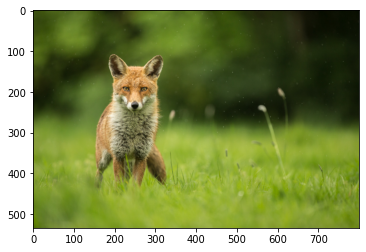

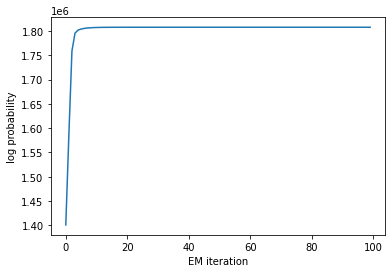

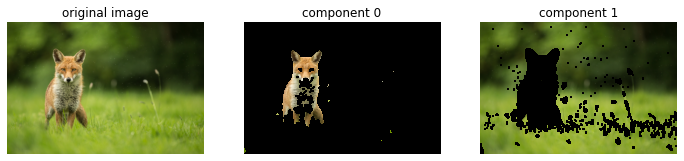

In [23]:
run_segmentation("fox")

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


fox results:
Cluster  0 :
	 mu:     tensor([0.5657, 0.5048, 0.3228])
	 Sigma:  tensor([[0.0477, 0.0375, 0.0314],
        [0.0375, 0.0330, 0.0288],
        [0.0314, 0.0288, 0.0286]])
	 probs:  tensor(0.1034)

Cluster  1 :
	 mu:     tensor([0.5370, 0.6366, 0.2015])
	 Sigma:  tensor([[0.0058, 0.0051, 0.0028],
        [0.0051, 0.0046, 0.0022],
        [0.0028, 0.0022, 0.0032]])
	 probs:  tensor(0.4393)

Cluster  2 :
	 mu:     tensor([0.1979, 0.2598, 0.0803])
	 Sigma:  tensor([[0.0096, 0.0119, 0.0039],
        [0.0119, 0.0149, 0.0048],
        [0.0039, 0.0048, 0.0020]])
	 probs:  tensor(0.4573)



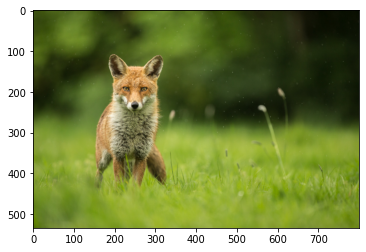

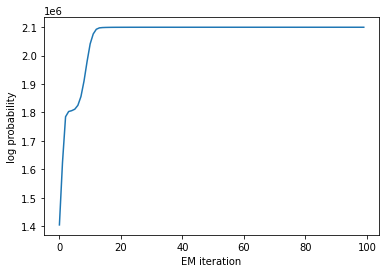

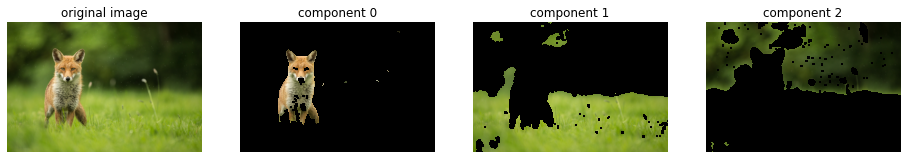

In [24]:
run_segmentation("fox", K=3)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


cow results:
Cluster  0 :
	 mu:     tensor([0.2453, 0.2477, 0.1971])
	 Sigma:  tensor([[0.0673, 0.0650, 0.0578],
        [0.0650, 0.0637, 0.0559],
        [0.0578, 0.0559, 0.0511]])
	 probs:  tensor(0.1191)

Cluster  1 :
	 mu:     tensor([0.2692, 0.3443, 0.1840])
	 Sigma:  tensor([[0.0015, 0.0014, 0.0013],
        [0.0014, 0.0014, 0.0013],
        [0.0013, 0.0013, 0.0014]])
	 probs:  tensor(0.8809)



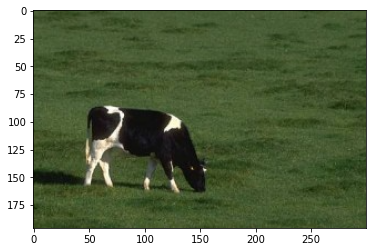

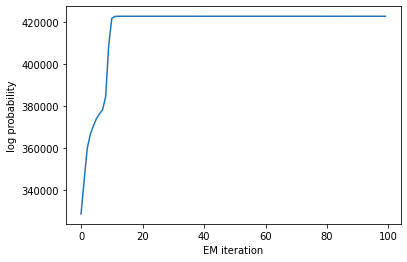

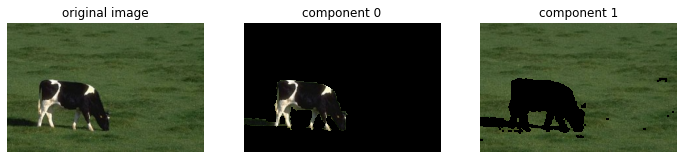

In [25]:
run_segmentation("cow")

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


cow results:
Cluster  0 :
	 mu:     tensor([0.6680, 0.6543, 0.5647])
	 Sigma:  tensor([[0.0645, 0.0599, 0.0584],
        [0.0599, 0.0574, 0.0554],
        [0.0584, 0.0554, 0.0563]])
	 probs:  tensor(0.0265)

Cluster  1 :
	 mu:     tensor([0.1390, 0.1494, 0.1009])
	 Sigma:  tensor([[0.0077, 0.0084, 0.0048],
        [0.0084, 0.0103, 0.0052],
        [0.0048, 0.0052, 0.0038]])
	 probs:  tensor(0.1013)

Cluster  2 :
	 mu:     tensor([0.2695, 0.3448, 0.1844])
	 Sigma:  tensor([[0.0014, 0.0014, 0.0013],
        [0.0014, 0.0014, 0.0013],
        [0.0013, 0.0013, 0.0013]])
	 probs:  tensor(0.8722)



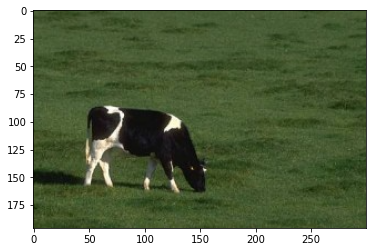

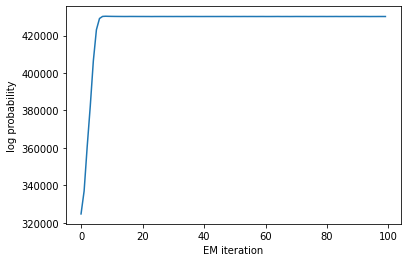

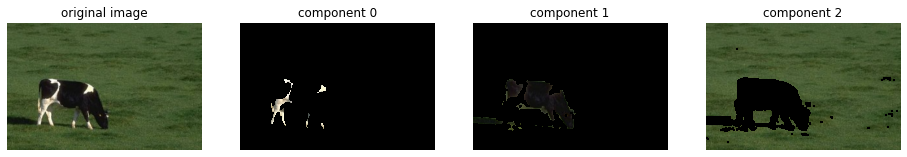

In [26]:
run_segmentation("cow", K=3)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


owl results:
Cluster  0 :
	 mu:     tensor([0.8054, 0.7737, 0.7144])
	 Sigma:  tensor([[0.0184, 0.0223, 0.0272],
        [0.0223, 0.0285, 0.0351],
        [0.0272, 0.0351, 0.0458]])
	 probs:  tensor(0.0969)

Cluster  1 :
	 mu:     tensor([0.7371, 0.6383, 0.4863])
	 Sigma:  tensor([[0.0014, 0.0016, 0.0017],
        [0.0016, 0.0019, 0.0020],
        [0.0017, 0.0020, 0.0023]])
	 probs:  tensor(0.9031)



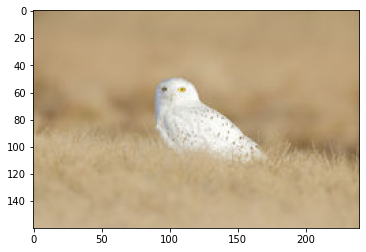

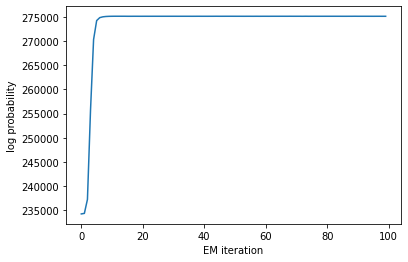

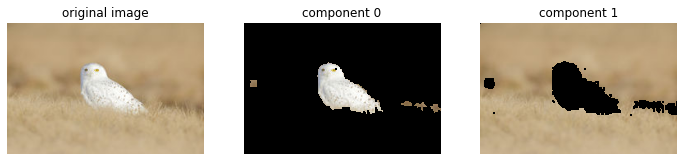

In [27]:
run_segmentation("owl")

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


owl results:
Cluster  0 :
	 mu:     tensor([0.8620, 0.8501, 0.8162])
	 Sigma:  tensor([[0.0085, 0.0086, 0.0090],
        [0.0086, 0.0099, 0.0104],
        [0.0090, 0.0104, 0.0128]])
	 probs:  tensor(0.0749)

Cluster  1 :
	 mu:     tensor([0.7377, 0.6390, 0.4871])
	 Sigma:  tensor([[0.0014, 0.0015, 0.0016],
        [0.0015, 0.0019, 0.0020],
        [0.0016, 0.0020, 0.0022]])
	 probs:  tensor(0.8992)

Cluster  2 :
	 mu:     tensor([0.6014, 0.5000, 0.3524])
	 Sigma:  tensor([[0.0039, 0.0028, 0.0015],
        [0.0028, 0.0041, 0.0018],
        [0.0015, 0.0018, 0.0034]])
	 probs:  tensor(0.0259)



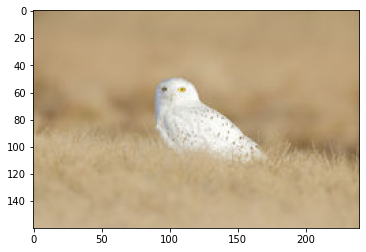

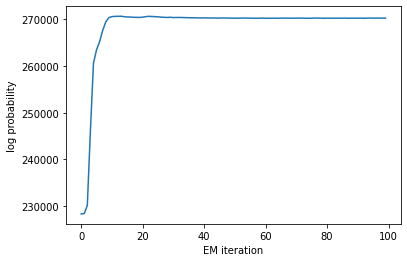

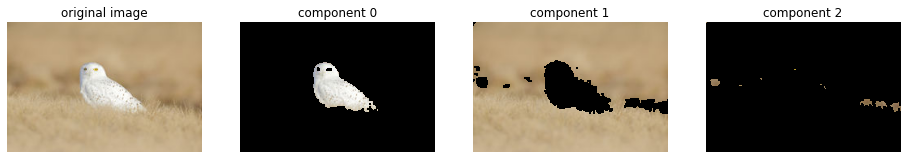

In [28]:
run_segmentation("owl", K=3)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


zebra results:
Cluster  0 :
	 mu:     tensor([0.6098, 0.6605, 0.3382])
	 Sigma:  tensor([[0.0068, 0.0049, 0.0062],
        [0.0049, 0.0049, 0.0050],
        [0.0062, 0.0050, 0.0072]])
	 probs:  tensor(0.6799)

Cluster  1 :
	 mu:     tensor([0.3281, 0.2923, 0.2669])
	 Sigma:  tensor([[0.0823, 0.0813, 0.0785],
        [0.0813, 0.0829, 0.0796],
        [0.0785, 0.0796, 0.0799]])
	 probs:  tensor(0.3201)



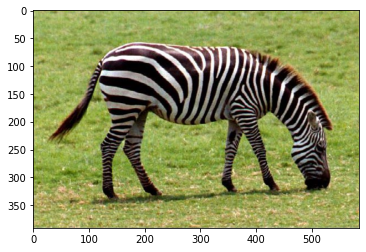

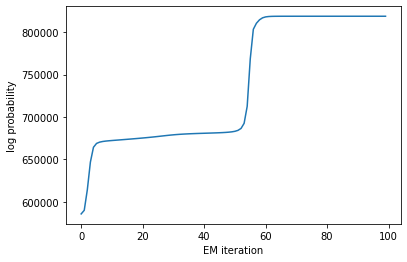

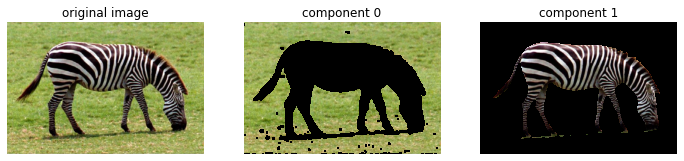

In [29]:
run_segmentation("zebra")

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


zebra results:
Cluster  0 :
	 mu:     tensor([0.6087, 0.6648, 0.3381])
	 Sigma:  tensor([[0.0053, 0.0038, 0.0050],
        [0.0038, 0.0038, 0.0040],
        [0.0050, 0.0040, 0.0061]])
	 probs:  tensor(0.6253)

Cluster  1 :
	 mu:     tensor([0.4784, 0.4453, 0.4356])
	 Sigma:  tensor([[0.0788, 0.0813, 0.0812],
        [0.0813, 0.0856, 0.0853],
        [0.0812, 0.0853, 0.0860]])
	 probs:  tensor(0.1548)

Cluster  2 :
	 mu:     tensor([0.4772, 0.4404, 0.2727])
	 Sigma:  tensor([[0.0455, 0.0431, 0.0307],
        [0.0431, 0.0463, 0.0294],
        [0.0307, 0.0294, 0.0259]])
	 probs:  tensor(0.1294)

Cluster  3 :
	 mu:     tensor([0.0339, 0.0098, 0.0128])
	 Sigma:  tensor([[7.9809e-04, 1.4777e-04, 1.0206e-04],
        [1.4777e-04, 1.9926e-04, 8.1995e-05],
        [1.0206e-04, 8.1995e-05, 2.6713e-04]])
	 probs:  tensor(0.0905)



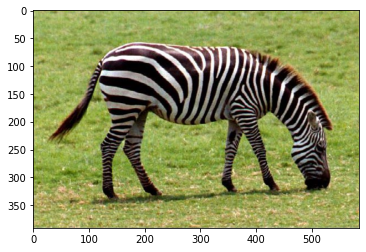

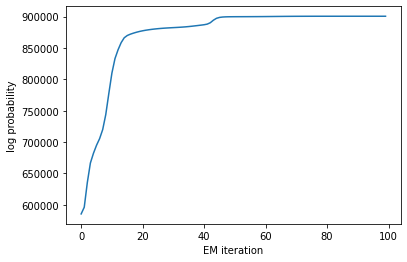

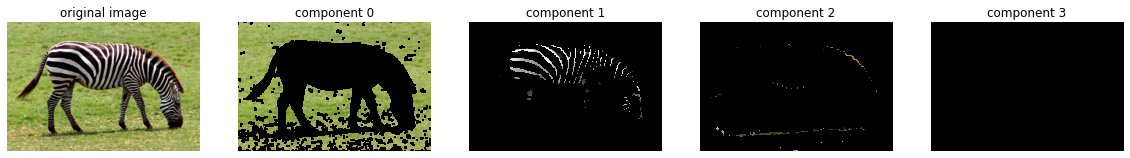

In [30]:
run_segmentation("zebra", K=4)

## Problem 3a: Multiple restarts
Explain why you might need multiple restarts for EM to obtain the best results.


---

As has been discussed in class, the EM ascent is not necessarily convex -- one could get stuck in a local optimum, and thurs return a non-sensical segmentation. Further, if we initialized parameters across all clusters evenly (i.e. $\mu_1 = \mu_2 =\ldots, \Sigma_1 = \Sigma_2 = \ldots, $ and with uniform priors, the EM would fail to move at all; hence a restart with different initialization would be necessary.

---

## Problem 3b: Model improvements

How could you extend this model -- e.g. by building in more prior information about images -- to improve the background segmentations? 


---

Currently, the model assumes independence between each $n=1, \ldots, N$, and evaluates that pixel's cluster in a vacuum/in isolation. In other words, pixels have no spatial relationship with one another. One possible way to improve this would be to pursue a model that does consider such spatial relationships, whether through covariance structures or more convolutional-y architectures.

---

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw4_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf files to Gradescope. 